### Import Needed Packages

In [1]:
import os

import plotly.express as px
import xarray as xr

import basd

### Root data path

In [2]:
data_path = '../../../OneDrive - PNNL/Documents/BASD/data'

# Precipitation Data

Here we will adjust precipitation output from NCAR's CESM2-WACCM model using observational data from EWEMBI.

First we set the paths to our data:

In [3]:
#obs_hist_path = 'pr_day_CESM2-WACCM_historical_r2i1p1f1_gn_20100101-20150101.nc'
pr_obs_hist_path = 'pr_ewembi_2011_2016.nc4'
pr_sim_hist_path = 'pr_day_CESM2-WACCM_historical_r1i1p1f1_gn_20100101-20150101.nc'
pr_sim_fut_path = 'pr_day_CESM2-WACCM_ssp370_r1i1p1f1_gn_20950101-21010101.nc'

and read in our data using the `xarray` package

In [4]:
pr_obs_hist = xr.open_dataset(os.path.join(data_path, pr_obs_hist_path),
                              decode_coords = 'all')
pr_sim_hist = xr.open_dataset(os.path.join(data_path, pr_sim_hist_path),
                              decode_coords = 'all')
pr_sim_fut = xr.open_dataset(os.path.join(data_path, pr_sim_fut_path),
                             decode_coords = 'all')

C:\Users\prim232\virtualenvs\basd-dev\lib\site-packages\xarray\conventions.py:522: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
C:\Users\prim232\AppData\Local\Temp\ipykernel_21524\4286948841.py:3: UserWarning: Variable(s) referenced in cell_measures not in variables: ['areacella']
  pr_sim_hist = xr.open_dataset(os.path.join(data_path, pr_sim_hist_path),
C:\Users\prim232\AppData\Local\Temp\ipykernel_21524\4286948841.py:5: UserWarning: Variable(s) referenced in cell_measures not in variables: ['areacella']
  pr_sim_fut = xr.open_dataset(os.path.join(data_path, pr_sim_fut_path),


## Setting parameters and creating Adjustment Object
For precipitation, we set the following parameters:

* Lower bound: 0
* Lower threshold: 0.0000011547
* Trend preservation method: 'mixed'
* Distribution: 'gamma'
* Value to set cells with only invalid values: 0

We then create the bias adjustment object with our data, parameters object, and ask to have our data remapped to match in resolution. This is needed in this case as the EWEMBI data is 360x720 (lat x lon), where CESM2-WACCM is 192x288.

In [5]:
params = basd.Parameters(lower_bound=0,
                         lower_threshold=0.0000011574,
                         trend_preservation='mixed',
                         distribution='gamma',
                         if_all_invalid_use=0)
pr_ba = basd.Adjustment(pr_obs_hist,
                        pr_sim_hist,
                        pr_sim_fut,
                        'pr',
                        params,
                        remap_grid=True)

C:\Users\prim232\virtualenvs\basd-dev\lib\site-packages\xarray\coding\cftime_offsets.py:1130: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  return pd.date_range(
C:\Users\prim232\virtualenvs\basd-dev\lib\site-packages\xarray\coding\cftime_offsets.py:1130: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  return pd.date_range(


# Adjustment at one location
Here we ask to perform bias adjustment at the 100th row and 100th column cell position. This happens to correspond to 4.421 degrees latitude (on -90 to 90) and 125 degrees longitude (on -180 to 180). This choice was arbitrary.

Note that to run a full grid adjustment, one would use `pr_ba.adjust_bias()`. However, this is extremely computationally extensive and is recommended to be run on computing cluster to make use of the parallel implementation of this function.

In [43]:
pr_sim_fut_ba_loc = pr_ba.adjust_bias_one_location(dict(lat=100, lon=100))

# Plots

### Histogram
This plot shows the distribution of precipitation over the time period Jan 1, 2095 - Dec 31, 2100 (our input simulated future period) at our given grid cell, before and after bias adjustment.

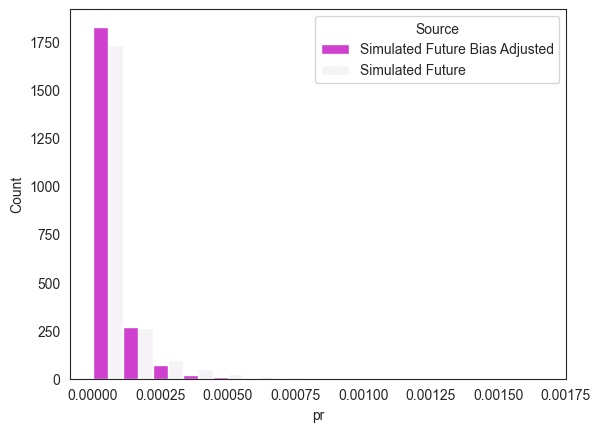

In [44]:
pr_sim_fut_ba_loc.plot_hist()

### Empirical CDF
This plot gives the empirical CDFs of precipitation for each of our input data, and bias adjusted result, at the given grid cell.

We can see here how the relationship between the observational and simulated historical data, is indeed transferred from the simulated future data to the bias adjusted result.

In [45]:
pr_sim_fut_ba_loc.plot_ecdf(log_x=True)

# Shortwave Radiation Data

Now we will adjust surface downwelling shortwave radiation output from MIROC's model using observational data from EWEMBI.

Again we set the paths to our data:

In [22]:
rsds_obs_hist_path = 'rsds_ewembi_2011_2016.nc4'
rsds_sim_hist_path = 'rsds_day_MIROC6_historical_r2i1p1f1_gn_20100101-20141231.nc'
rsds_sim_fut_path = 'rsds_day_MIROC6_ssp370_r2i1p1f1_gn_20150101-20241231.nc'

reading in with `xarray`:

In [27]:
rsds_obs_hist = xr.open_dataset(os.path.join(data_path, rsds_obs_hist_path),
                                decode_coords = 'all')
rsds_sim_hist = xr.open_dataset(os.path.join(data_path, rsds_sim_hist_path),
                                decode_coords = 'all')
rsds_sim_fut = xr.open_dataset(os.path.join(data_path, rsds_sim_fut_path),
                               decode_coords = 'all')

C:\Users\prim232\AppData\Local\Temp\ipykernel_1272\1535481193.py:3: UserWarning:

Variable(s) referenced in cell_measures not in variables: ['areacella']

C:\Users\prim232\AppData\Local\Temp\ipykernel_1272\1535481193.py:5: UserWarning:

Variable(s) referenced in cell_measures not in variables: ['areacella']



## Creating Parameter and Adjustment Objects
For `rsds` we have a bit more involved process to set up the bias adjustment, though that is all taken care of for us when we specify parameters. This is because we are going to first scale `rsds` to the interval [0,1], at which point is assumed to follow a Beta distribution. We'll then set our remaining parameters accordingly.

Our data is scaled to [0,1] by setting each observation to be how large the observation is compared to the largest observation in a surrounding window. We get to choose how large the window by specifying the half width (so number of days just before or after). Here we set a half running window size of 15, thus a full window size of 31.

Again, we also want to remap the observational data to match the simulated data's resolution.


In [32]:
rsds_params = basd.Parameters(halfwin_ubc=15,
                              trend_preservation='bounded',
                              distribution='beta',
                              lower_bound=0,
                              upper_bound=1,
                              lower_threshold=0.0001,
                              upper_threshold=0.9999,
                              if_all_invalid_use=0)
rsds_ba = basd.Adjustment(rsds_obs_hist,
                          rsds_sim_hist,
                          rsds_sim_fut,
                          'rsds',
                          rsds_params,
                          remap_grid=True)

# Adjustment at one location
Here we ask to perform bias adjustment at the 100th row and 100th column cell position. This time this happens to correspond to 51.1 degrees latitude and 140.6 degrees longitude. Again, arbitrarily selected.

In [33]:
rsds_sim_fut_ba_loc = rsds_ba.adjust_bias_one_location(dict(lat=100, lon=100))

# Plots II

### Histogram
Shows the distribution of surface downwelling shortwave radiation before and after bias adjustment at the chosen grid cell.

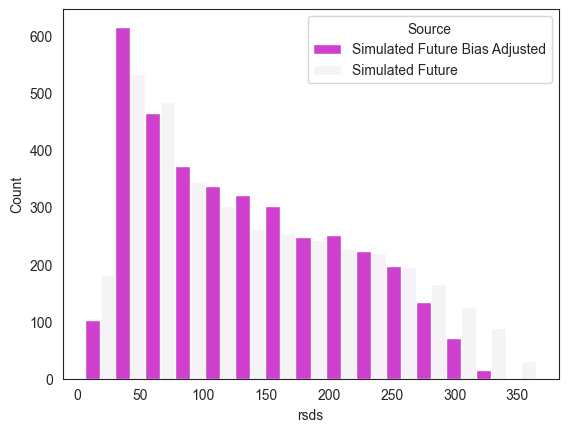

In [34]:
rsds_sim_fut_ba_loc.plot_hist()

### Empirical CDF
Shows the empirical CDFs for each input data source and resulting adjustment time series, at the chosen grid cell.

In [38]:
px.ecdf(rsds_sim_fut_ba_loc.time_series, x='rsds', color='Source')